In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scipy
import statsmodels.formula.api as smf
import random
from scipy.stats import iqr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df_salary = pd.read_csv('salary.csv')
df_salary[df_salary.salary.isnull()]

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
208,NaN,0,21,10,0.93,1,0,3,1,4,1


In [3]:
#Drop Nan values is salary column
df_salary = df_salary.dropna()

#Rename as per metadata
df_salary =df_salary.rename(columns ={'male':'gender', 'experior':'Experience', 'yearsabs':'years_absent'})
df_salary.gender = ['male' if i == 1 else 'female' for i in df_salary.gender]
df_salary.position = ['Jnr_employee' if i == 1 else 'Manager' if  i == 2 else 'Executive' for i in df_salary.position]
df_salary.Field = ['Engineering' if i == 1 else 'Finance' if i == 2 else 'Human Resource' if i == 3 else 'Marketing' for i in df_salary.Field]    
df_salary = pd.DataFrame(df_salary)
df_salary

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,gender,Field,years_absent
0,53000.0,0,0,0,1.17,1,0,Jnr_employee,male,Human Resource,0
1,58000.0,1,0,0,1.24,1,0,Jnr_employee,male,Finance,0
2,45500.0,0,0,0,1.21,1,0,Jnr_employee,male,Human Resource,2
3,35782.0,0,2,1,0.99,1,0,Jnr_employee,male,Marketing,1
4,34731.0,0,2,2,0.91,1,0,Jnr_employee,male,Marketing,1
...,...,...,...,...,...,...,...,...,...,...,...
509,45906.0,6,17,11,0.92,1,0,Manager,female,Finance,70
510,60402.0,6,19,7,0.86,1,0,Executive,female,Engineering,72
511,53187.0,19,7,6,0.78,1,0,Executive,female,Marketing,76
512,56542.0,8,20,10,0.78,1,0,Executive,female,Finance,78


### 1.1 Split your data into a training and test set.

In [4]:
#Splitting the data into the train and test set"
split = len(df_salary)*0.8
print("80% of the data set must contain ",round(split), 'rows')
df_sample = df_salary.loc[:,['salary','yearsworked','position','gender','Field','yearsrank','market','years_absent']]
df_train =  df_sample.loc[:split,:]
df_test = df_sample.loc[split:,:]
df_train

80% of the data set must contain  410 rows


,salary,yearsworked,position,gender,Field,yearsrank,market,years_absent
0,53000.0,0,Jnr_employee,male,Human Resource,0,1.17,0
1,58000.0,0,Jnr_employee,male,Finance,0,1.24,0
2,45500.0,0,Jnr_employee,male,Human Resource,0,1.21,2
3,35782.0,2,Jnr_employee,male,Marketing,1,0.99,1
4,34731.0,2,Jnr_employee,male,Marketing,2,0.91,1
...,...,...,...,...,...,...,...,...
406,33680.0,3,Jnr_employee,female,Human Resource,3,0.92,4
407,35000.0,0,Jnr_employee,female,Human Resource,0,0.91,4
408,36833.0,3,Jnr_employee,female,Marketing,3,0.84,1
409,31000.0,0,Jnr_employee,female,Human Resource,0,0.95,1


### About the DataFrame: df_Salary
1. There are **514 entries/observation** in this dataset meaning that **514 employees'** data is recorded.
2. There is **one null value** in *Salary column*
3. The *gender* column contains **two unique values of type object: male or female**
4. The *Experience,years worked, years rank* columns contains **continuous values of type int*
5. *Market* column contains **continuous value of type float**
6. The *position* and *field* column contains **three unique values of type object(pandas string): {Jnr Employee, Executive or Manager} and {Human Resource, Finance or Engineering} respectively** 
   

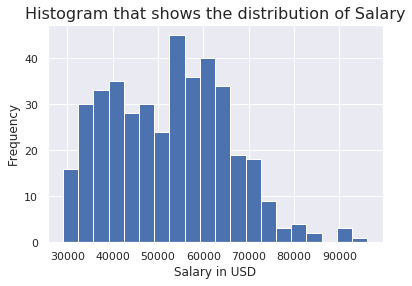

In [5]:
sns.set()
plt.hist(df_train.salary, bins=20)

plt.title('Histogram that shows the distribution of Salary', fontsize=16)
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.show()



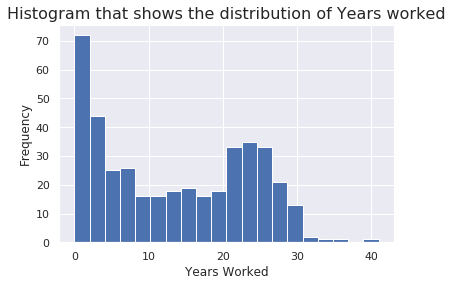

In [6]:
sns.set()
plt.hist(df_train.yearsworked, bins=20)
plt.title('Histogram that shows the distribution of Years worked', fontsize=16)
plt.xlabel('Years Worked')
plt.ylabel('Frequency')
plt.show()

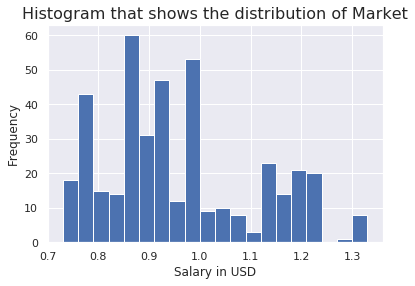

In [7]:
sns.set()
plt.hist(df_train.market, bins=20)

plt.title('Histogram that shows the distribution of Market', fontsize=16)
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.show()


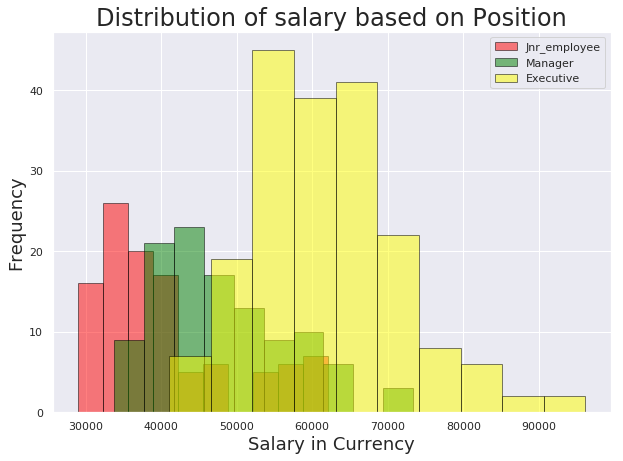

In [8]:
df_train[df_train['position']=='Jnr_employee'].salary.plot(kind='hist',color='red',edgecolor='black',alpha=0.5,figsize=(10,7))
df_train[df_train['position']=='Manager'].salary.plot(kind='hist',color='green',edgecolor='black',alpha=0.5,figsize=(10,7))
df_train[df_train['position']=='Executive'].salary.plot(kind='hist',color='yellow',edgecolor='black',alpha=0.5,figsize=(10,7))
plt.legend(labels=['Jnr_employee','Manager','Executive'])
plt.title('Distribution of salary based on Position', size=24)
plt.xlabel('Salary in Currency', size=18)
plt.ylabel('Frequency', size=18);

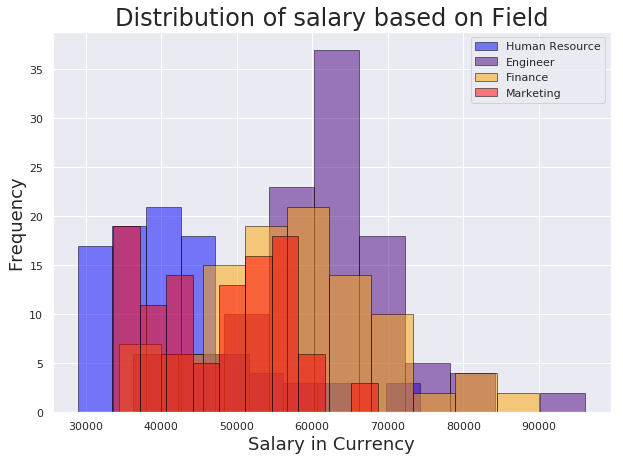

In [9]:
df_train[df_train['Field']=='Human Resource'].salary.plot(kind='hist',color='blue',edgecolor='black',alpha=0.5,figsize=(10,7))
df_train[df_train['Field']=='Engineering'].salary.plot(kind='hist',color='indigo',edgecolor='black',alpha=0.5,figsize=(10,7))
df_train[df_train['Field']=='Finance'].salary.plot(kind='hist',color='orange',edgecolor='black',alpha=0.5,figsize=(10,7))
df_train[df_train['Field']=='Marketing'].salary.plot(kind='hist',color='red',edgecolor='black',alpha=0.5,figsize=(10,7))
plt.legend(labels=['Human Resource','Engineer','Finance','Marketing'])
plt.title('Distribution of salary based on Field', size=24)
plt.xlabel('Salary in Currency', size=18)
plt.ylabel('Frequency', size=18);

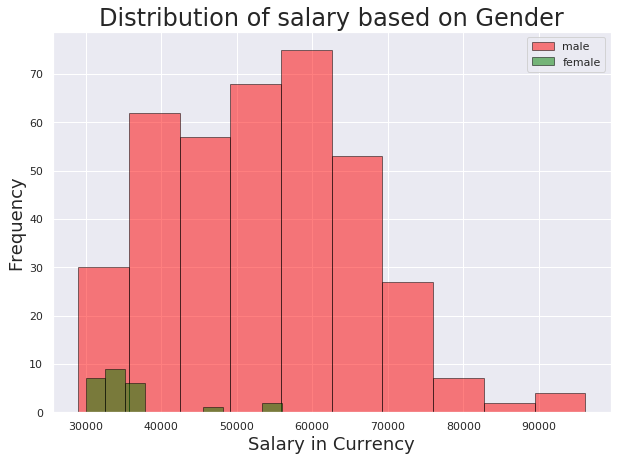

In [10]:
df_train[df_train['gender']=='male'].salary.plot(kind='hist',color='red',edgecolor='black',alpha=0.5,figsize=(10,7))
df_train[df_train['gender']=='female'].salary.plot(kind='hist',color='green',edgecolor='black',alpha=0.5,figsize=(10,7))

plt.legend(labels=['male','female'])
plt.title('Distribution of salary based on Gender', size=24)
plt.xlabel('Salary in Currency', size=18)
plt.ylabel('Frequency', size=18);

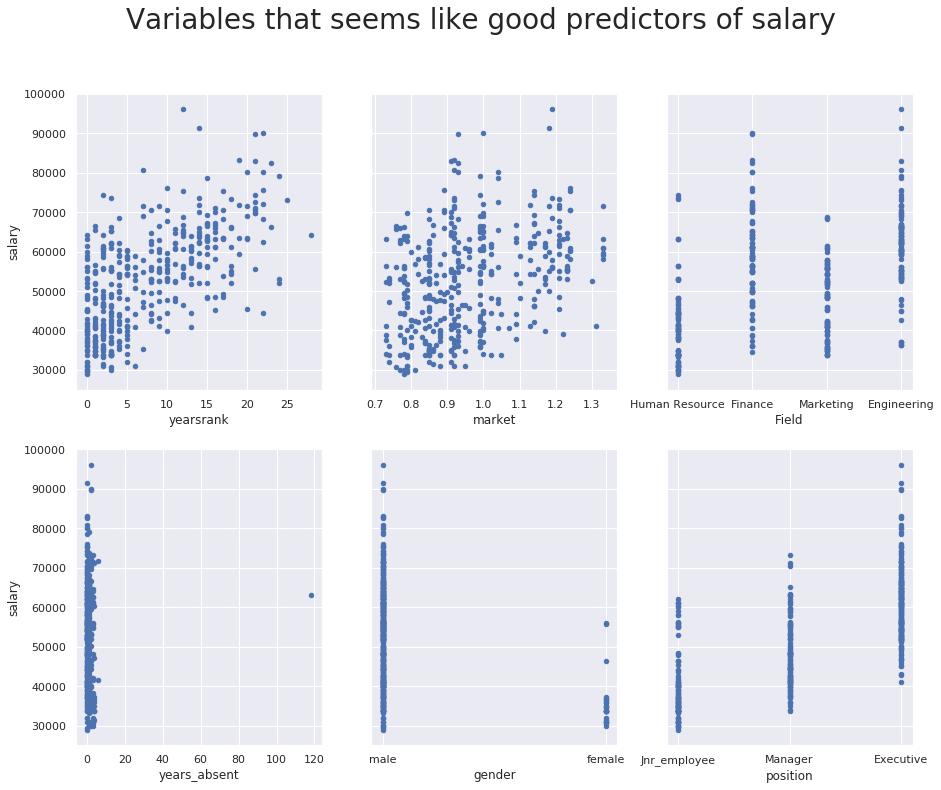

In [11]:
# Reducing the level of the axis logger to error:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
sns.set()
fig, axs = plt.subplots(2, 3,sharey=True)
fig.suptitle('Variables that seems like good predictors of salary', fontsize=28)
df_train.plot(kind='scatter', x='yearsrank', y='salary', ax=axs[0,0],figsize=(15, 12))
df_train.plot(kind='scatter', x='market', y='salary', ax=axs[0,1])   
df_train.plot(kind='scatter', x='Field', y='salary', ax=axs[0,2])
df_train.plot(kind='scatter', x='years_absent', y='salary', ax=axs[1,0])
df_train.plot(kind='scatter', x='gender', y='salary', ax=axs[1,1])
df_train.plot(kind='scatter', x='position', y='salary', ax=axs[1,2])
plt.show()

In [12]:
df_dummies =pd.get_dummies(df_train.Field).loc[:,['Engineering','Finance']]
df_dummies

,Engineering,Finance
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
406,0,0
407,0,0
408,0,0
409,0,0


In [13]:
#Check for outliers:Train
q75_train, q25_train = np.percentile(df_train['salary'], [75 ,25])
iqr_train = q75_train - q25_train
lower_bound = q25_train - iqr_train*1.5
upper_bound = q75_train + iqr_train*1.5

q75_test, q25_test = np.percentile(df_test['salary'], [75 ,25])
iqr_test = q75_test - q25_test
test_lower_bound = q25_test - iqr_test*1.5
test_upper_bound = q75_test + iqr_test*1.5
print('Q1 for training set: $',q25_train)
print('Q3 for training set: $',q75_train)
print('Lower outlier boundry: $',lower_bound )
print('Upper outlier boundry: $',upper_bound )

print('Q1 for testing set: $',q25_test)
print('Q3 for testing set: $',q75_test)
print('Lower outlier boundry: $',test_lower_bound )
print('Upper outlier boundry: $',test_upper_bound )

Q1 for training set: $ 41109.75
Q3 for training set: $ 61722.25
Lower outlier boundry: $ 10191.0
Upper outlier boundry: $ 92641.0
Q1 for testing set: $ 37487.0
Q3 for testing set: $ 50144.0
Lower outlier boundry: $ 18501.5
Upper outlier boundry: $ 69129.5


In [14]:
df_train['Is_it_an_extreme'] = ['Yes' if i < lower_bound else 'Yes' if i > upper_bound else "No" for i in df_train.salary]
df_outliers = df_train[df_train.Is_it_an_extreme == 'Yes']
df_test['Is_it_an_extreme'] = ['Yes' if i < test_lower_bound else 'Yes' if i > test_upper_bound else "No" for i in df_test.salary]
df_test_outliers = df_test[df_test.Is_it_an_extreme == 'Yes']
df_outliers

,salary,yearsworked,position,gender,Field,yearsrank,market,years_absent,Is_it_an_extreme
377,96156.0,12,Executive,male,Engineering,12,1.19,2,Yes


In [15]:
df_test_outliers

,salary,yearsworked,position,gender,Field,yearsrank,market,years_absent,Is_it_an_extreme
481,69654.33594,17,Manager,female,Engineering,12,1.21,44,Yes


In [16]:
df_train = df_train[df_train.Is_it_an_extreme != 'Yes']
df_test = df_test[df_test.Is_it_an_extreme != 'Yes']

In [17]:
df_train.corr(method='pearson')

,salary,yearsworked,yearsrank,market,years_absent
salary,1.000000,0.643694,0.647257,0.361245,0.009643
yearsworked,0.643694,1.000000,0.821622,-0.093919,0.036941
yearsrank,0.647257,0.821622,1.000000,-0.047293,0.073408
market,0.361245,-0.093919,-0.047293,1.000000,-0.078674
years_absent,0.009643,0.036941,0.073408,-0.078674,1.000000


In [18]:
df_train.corr(method='kendall')

,salary,yearsworked,yearsrank,market,years_absent
salary,1.000000,0.474080,0.464802,0.251513,-0.131108
yearsworked,0.474080,1.000000,0.672653,-0.043884,-0.109107
yearsrank,0.464802,0.672653,1.000000,-0.017681,-0.072836
market,0.251513,-0.043884,-0.017681,1.000000,-0.056204
years_absent,-0.131108,-0.109107,-0.072836,-0.056204,1.000000


In [19]:
df_train.corr(method='spearman')

,salary,yearsworked,yearsrank,market,years_absent
salary,1.000000,0.646556,0.633087,0.370511,-0.169148
yearsworked,0.646556,1.000000,0.813512,-0.062384,-0.136986
yearsrank,0.633087,0.813512,1.000000,-0.025260,-0.090368
market,0.370511,-0.062384,-0.025260,1.000000,-0.071348
years_absent,-0.169148,-0.136986,-0.090368,-0.071348,1.000000


### Is there any multicollinearity or other problems that may be a problem in the multiple regression
 <p> Looking at the above correlation coefficients. There's is a moderarate positive relationship between salary and years worked and there's is a moderarate positive relationship between salary and years. This shows multicollinearity. Given, a function that assess salary as a function:</p>

   **Y’ = B0 + B1X1 + B2X2**  where:

*  Y' : Is the predicted dependent variable salary
*  B0 : Is the intercept of the regression line
* X1: Predicting independent variable: Years worked
* B1: Is the marginal effect on salary of one additional year worked, holding other variables constant.
* X2: Predicting independent variable: Years rank
* B2: Is the marginal effect on salary of one additional year ranked, holding other variables constant.

What the regression model is going to do is to disentangle the individual effects of years worked and years rank on salary. Given the opportunity that the regression model does tease apart these individual effects, such individual effects become obscured. Multicolinearity happens when the X variables are themselves related.

This is a perfect description for multicolinearity, if one year a experience is added, the likelihood that one stays in that rank for one more year is close to 100%, so the regression model will have a very unrealistic way of analysing if the effect on salary was due to one more year of experience or one more year of being in that particular rank.


In [20]:
import statsmodels.formula.api as smf
# create a fitted model: salary vs years worked
model= smf.ols(formula='salary ~ yearsworked', data=df_train).fit()
model.params

Intercept      40964.907588
yearsworked      837.814467
dtype: float64

In [21]:
# print the confidence intervals for the model coefficients
model.conf_int()

,0,1
Intercept,39337.106262,42592.708913
yearsworked,740.755684,934.873250


In [22]:
# create a fitted model: salary vs yearsrank
model1= smf.ols(formula='salary ~ yearsrank', data=df_train).fit()
model1.params

Intercept    43074.992197
yearsrank     1234.706778
dtype: float64

In [23]:
# print the confidence intervals for the model coefficients
model1.conf_int()

,0,1
Intercept,41647.814859,44502.169535
yearsrank,1093.015959,1376.397597


In [24]:
# create a fitted model: salary vs market
model2= smf.ols(formula='salary ~ market', data=df_train).fit()
model2.params

Intercept    22640.874951
market       30912.792315
dtype: float64

In [25]:
# print the confidence intervals for the model coefficients
model2.conf_int()

,0,1
Intercept,15082.015081,30199.734820
market,23137.512876,38688.071753


In [26]:
# create a fitted model: salary vs years absent
model3= smf.ols(formula='salary ~ years_absent', data=df_train).fit()
model3.params

Intercept       52311.913703
years_absent       20.997163
dtype: float64

In [27]:
# print the confidence intervals for the model coefficients
model3.conf_int()

,0,1
Intercept,51042.583328,53581.244078
years_absent,-191.163951,233.158278


In [28]:
df_train.salary.mean()

52333.7836091198

### Predictions`

In [29]:
df_train.head()

,salary,yearsworked,position,gender,Field,yearsrank,market,years_absent,Is_it_an_extreme
0,53000.0,0,Jnr_employee,male,Human Resource,0,1.17,0,No
1,58000.0,0,Jnr_employee,male,Finance,0,1.24,0,No
2,45500.0,0,Jnr_employee,male,Human Resource,0,1.21,2,No
3,35782.0,2,Jnr_employee,male,Marketing,1,0.99,1,No
4,34731.0,2,Jnr_employee,male,Marketing,2,0.91,1,No


In [30]:
df_train.describe()

,salary,yearsworked,yearsrank,market,years_absent
count,409.000000,409.000000,409.000000,409.000000,409.000000
mean,52333.783609,13.569682,7.498778,0.960538,1.041565
std,12843.964788,9.868034,6.733049,0.150094,5.898715
min,29000.000000,0.000000,0.000000,0.730000,0.000000
25%,41106.000000,4.000000,2.000000,0.850000,0.000000
50%,53010.000000,13.000000,5.000000,0.920000,0.000000
75%,61453.000000,23.000000,13.000000,1.040000,1.000000
max,91405.000000,41.000000,28.000000,1.330000,118.000000


In [31]:
x = pd.DataFrame({'yearsworked':[13.565854]})
model.predict(x)

0    52330.576328
dtype: float64

In [32]:
x1 = pd.DataFrame({'yearsworked':[41]})
model.predict(x1)

0    75315.300742
dtype: float64

In [33]:
y1 = pd.DataFrame({'yearsrank':[7.509756]})
model1.predict(y1)

0    52347.33883
dtype: float64

In [34]:
y2 = pd.DataFrame({'yearsrank':[25]})
model1.predict(y2)

0    73942.661642
dtype: float64

In [35]:
b1 = pd.DataFrame({'market':[0.960538]})
model2.predict(b1)

0    52333.786655
dtype: float64

In [36]:
b2 = pd.DataFrame({'market':[1.330000]})
model2.predict(b2)

0    63754.888729
dtype: float64

In [37]:
c1 = pd.DataFrame({'years_absent':[1.041565]})
model3.predict(c1)

0    52333.783613
dtype: float64

In [38]:
c2 = pd.DataFrame({'years_absent':[118]})
model3.predict(c2)

0    54789.578963
dtype: float64

### Examine the training data for Extreme Values

In [61]:
df_train1 = model.predict(df_train)
df_train1 = pd.DataFrame(df_train1)
df_train1= df_train1.rename(columns={0:'Predicted Salary'})
df_train1['Actual alary'] = df_train['salary']
df_train1

,Predicted Salary,Actual salary
0,40964.907588,53000.0
1,40964.907588,58000.0
2,40964.907588,45500.0
3,42640.536522,35782.0
4,42640.536522,34731.0
...,...,...
406,43478.350989,33680.0
407,40964.907588,35000.0
408,43478.350989,36833.0
409,40964.907588,31000.0


In [62]:
df_test1 = model.predict(df_test)
df_test1 = pd.DataFrame(df_test1)
df_test1 = df_test1.rename(columns={0:'Predicted Salary'})
df_test1['Actual Salary'] = df_test['salary']
df_test1 

,Predicted Salary,Actual Salary
411,42640.536522,34206.0
412,44316.165456,35574.0
413,40964.907588,59000.0
414,43478.350989,47344.0
415,43478.350989,35000.0
...,...,...
509,55207.753530,45906.0
510,56883.382464,60402.0
511,46829.608858,53187.0
512,57721.196931,56542.0


In [63]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_actual = df_train1['Actual Salary']
y_predicted = df_train1['Predicted Salary']
y_actual1 = df_test1['Actual Salary']
y_predicted1 = df_test1['Predicted Salary']
rms_test = sqrt(mean_squared_error(y_actual1,y_predicted1))
rms_train = sqrt(mean_squared_error(y_actual,y_predicted))
print('The RMSE of the train data is: ',rms_train)
print('And The RMSE of the test data is: ',rms_test,'which shows little to no signs of underfitting')

KeyError: 'Actual Salary'

In [56]:
# df_test1 = df_test1
# df_test1
# df_test1 = df_test1.rename(columns={0:'Predicted Salary'})
# from sklearn.metrics import mean_squared_error
# from math import sqrt


In [59]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# y_actual1 = df_test1['Actual Salary']
# y_predicted1 = df_test1['Predicted Salary']
# rms_test = sqrt(mean_squared_error(y_actual1,y_predicted1))
# rms_train = sqrt(mean_squared_error(y_actual1,y_predicted1))


The RMSE of the train data is:  9425.176111218478
And The RMSE of the test data is:  9425.176111218478 which shows little to no signs of underfitting


The train and test sets have 1 outlier each and thus they were dropped. 

#### Below is a summary statistics showing the statistics for every column in the data frame




### 1.3 Histograms to show the distribution between salary and other variables 

### 1.4 Scatterplot showing the relationship between Years Worked and Salary

### 2.  Using the statsmodels package and the training data, run a simple linear regression for Salary

**R > 0.6** Means there is a positive correlation between the variables

**R > 0.6** A moderate positive relationship

The correlation coefficient suggest that the data follows a linear relationship and it is normally distributed. The correlation coefficient is closer to 1 than it is to 0 which shows a moderate positive relationship between the two variables.

The **p_value** is too small and indicates strong evidence against the null hypothesis that the relationship between the variables is statistically significant since it is smaller than the *threshold* of the *P_value* of **p= 0.05**.

### 3. Meaning of a confidence interval

**From this, we can deduce that the true coefficient value of the salary population, will between these intervals. Simply put, if thousands of samples from a population was formed, this condition will hold 95% of the time.**

**This is a common shorthand for the idea that the calculations “work” 95% of the time. Only 5 % will this be not the case**

### 5. Calculate the expected salary for someone with 12 and 80 years’ work experience.

In [ ]:
f'Maximum years worked(in numbers) %s' %df_salary.yearsworked.max()

As per the model, it predicts that person who has worked for 12 years will earn, on average, the salary above. This value is interesting because the salary is not far off from the mean. This is because the mean for years worked is just over 12 years, meaning, on average, an employee at this company is to be expected to have worked for 12 years.

Yes there also seem to be a problem, the model predicts the salary level that is bigger than the maximum salary in the data set. The model assumes that people can work indefinetly and hence the prediction, in reality, rarely does a person spend 80 years in the workforce. Even in the data set the person who have worked longer than the rest only worked for 41 years.

### 7. What other employee characteristics might influence their salary

In [ ]:
df_salary.corr()

 This is how others are correlated with salary:

1. **Rank on salary**
Moderate positive correlation
2. **Experience**
Very Weak positive correlation
3. **Market**
Weak Positive correlation
4. **Degree**
5. Very weak positive correlation
6. **Other Qualification**
7. Ver weak positive correlation
8. **Years absent**
Negative correlation

In [ ]:
print('Below is the OLS regressionn summary:')
model.summary()


### 8. How does your model compare when running it on the test set - what is the difference in the Root Mean Square Error (RMSE) between the training and test sets? Is there any evidence of overfitting?


In [ ]:
df_train_comp = model.predict(df_train)
df_train_comp = pd.DataFrame(df_train_comp)
df_train_comp.rename(columns={0:'Predicted','salary':'Actual'})
df_train_comp['salary'] = df_train['salary']

In [ ]:
df_train_comp = df_train_comp.loc[:,['salary',0]]
df_train_comp.rename(columns={0:'Predicted'})
y_actual = df_train_comp.salary
y_predicted = df_train_comp[0]
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_train = sqrt(mean_squared_error(y_actual,y_predicted))


In [ ]:
# df_test_comp = model.predict(df_test)
# df_test_comp = pd.DataFrame(df_test_comp)
# df_test_comp.rename(columns={0:'Predicted'})
# df_test_comp['salary'] = df_test['salary']
# df_test_comp = df_test_comp.dropna()

In [ ]:
# df_test_comp = df_test_comp.loc[:,['salary',0]]
# df_test_comp.rename(columns={0:'Predicted', 'salary':'Actual'})
# df_test.salary.fillna(df_test.salary.mean())
# y_actual1 = df_test_comp.salary
# y_predicted1 = df_test_comp[0]
# rms_test = sqrt(mean_squared_error(y_actual1,y_predicted1))
# rms_train = sqrt(mean_squared_error(y_actual,y_predicted))


In [ ]:
print('The RMSE of the train data is: ',rms_train)
print('And The RMSE of the test data is: ',rms_test,'which shows little to no signs of underfitting')

In [ ]:
df_train.describe()